# South African Language Identification Hack 2022




<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    

In [3]:
#libraries for...
# Natural language libraries
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer

# General libraries
import numpy as np
import random
import pandas as pd
from collections import Counter
import string
import time
import math # For inbuilt math functions
import collections # used for dictionaries and counters
from itertools import permutations # used to find permutations

# Visualization libraries
import plotly.figure_factory as ff
import plotly.express as px
from plotly import graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.decomposition import PCA # Principal component analysis used to reduce the number of features in a model
from sklearn.preprocessing import StandardScaler # used to scale data to be used in the model


# Sklearn classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss

# Model Selection Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [4]:
nltk.download(['punkt','stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [5]:
# Function to load data
def load_data(file_path):
    """ Load the csv file and return a Dataframe. """
    df = pd.read_csv(file_path, delimiter=',')
    return df

In [6]:
train_data = load_data('/content/sample_data/train_set.csv')
test_data = load_data('/content/sample_data/test_set.csv')
submission = load_data('/content/sample_data/sample_submission.csv')

In [7]:
train_data.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [8]:
test_data.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [9]:
submission.head()

,index,lang_id
0,1,tsn
1,2,nbl


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



In [10]:
# Check for missing values in train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


There is no **missing value** in the train data set

List of languages:  ['xho' 'eng' 'nso' 'ven' 'tsn' 'nbl' 'zul' 'ssw' 'tso' 'sot' 'afr']



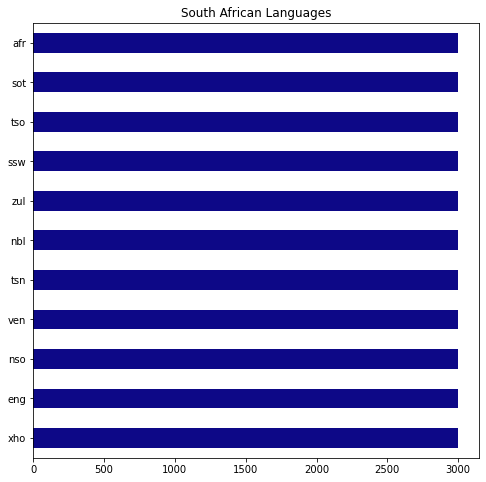

In [11]:
plt.figure(figsize=(8,8))
lang_id = train_data['lang_id'].unique()
print('List of languages: ', lang_id)
print()
train_data['lang_id'].value_counts().plot(kind='barh', title='South African Languages', cmap='plasma')

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



## **Feature Creation**
Set of features that will be used in the models for classifying text into eleven (11) South African languages listed below were generated from the train data: 

1.   **Ndebele**
2.   **Northern Sotho**
3.   **Sotho**
4.   **Zulu**
5.   **SiSwati**
6.   **Afrikaans**
7.   **Tsonga**
8.   **Tswana**
9.   **Venda**
10.  **Xhosa**
11.  **South African English** 

Different features may be more effective in classifying other languages. However, for the purpose of this project, the following features were generated :
1. **word_count**: Counts the words in each text observation. If the text input represents a sentence then the latter in some languages may have a tendency to be composed of more words.

2. **character_count**: Counts the number of non-space characters. Sentences or words in some languages may generally have more characters.

3. **word_density**: Divides the word_count by the character_count and creates an average relative relation between the latter two variables. This feature standardizes the length of a word based on how many words and characters there are in a text input.

4. **punc_count**: Counts the number of punctuations in a text input. Some languages may use more punctuations.

5. **dzh_dzw_char_count**: Counts the number of times the letters “dzh” and “dzw” are used in a text. Typically found in Venda language”. 

6. **num_double_consec_vowels:** Counts the number of same consecutive vowels in a text. 

7. **num_consec_vowels:** Counts the number of different consecutive vowels in a text. 

8. **num_vowels:** Number of vowels in a text.

9. **vowel_density:** Standardizes the number of vowels to the number of words in a text.

10. **num_punctuation:** Counts the number of punctuations in a text. Some languages may use more punctuation.

11. **num_unique_words**: Counts the number of unique words in a text. Some languages may use more unique words.

12. **num_repeated_words**: Counts the number of repeated words in a text. Some languages may repeat words more often.

13. **words_vs_unique**: Standadizes the number of unique words to the number of words in a text.

14. **encode_ascii**: Checks whether a text can be encoded using utf-8, which uses English characters. This feature will more likely be true for English text.

15. **aai_eei_char_count**: Counts the number of times the letters “aai” and “eei” are used in a text. Typically found in Venda language”.

16. **nts)_char_count**: Counts the number of times “nts” is repeated in the text. Typically found in Tswana language.

In [12]:
# Define a list of commonly found punctuations
punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
vowels=['a','e','i','o','u']
# Define a list of double consecutive vowels which are typically found in Dutch and Afrikaans languages
same_consecutive_vowels = ['aa','ee', 'ii', 'oo', 'uu']
africana_combos = ['aai', 'eeu'] 
consecutive_vowels = [''.join(p) for p in permutations(vowels,2)]
venda_combos = ['dzh', 'dzw']
tswana_combos = ['nts']

# Create a pre-defined set of features based on the "text" column in order to allow us to characterize the string
df = train_data.copy()
df['word_count'] = df['text'].apply(lambda x : len(x.split()))
df['character_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['character_count'] + 1)
df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc]))
df['v_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'v']))
df['w_char_count'] = df['text'].apply(lambda x : len([a for a in x if a.casefold() == 'w']))
df['nts_char_count'] = df['text'].apply(lambda x : sum([any(t_c in a for t_c in tswana_combos) for a in x.split()]))
df['aai_eeu_char_count'] = df['text'].apply(lambda x : sum([any(a_c in a for a_c in africana_combos) for a in x.split()]))
df['dzh_dzw_char_count'] = df['text'].apply(lambda x : sum([any(v_c in a for v_c in venda_combos) for a in x.split()]))
df['num_double_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in same_consecutive_vowels) for a in x.split()]))
df['num_consec_vowels'] = df['text'].apply(lambda x : sum([any(c_v in a for c_v in consecutive_vowels) for a in x.split()]))
df['num_vowels'] = df['text'].apply(lambda x : sum([any(v in a for v in vowels) for a in x.split()]))
df['vowel_density'] = df['num_vowels']/df['word_count']
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in punc))
df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
df['num_repeated_words'] = df['text'].apply(lambda x: len([w for w in collections.Counter(x.split()).values() if w > 1]))
df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
df['encode_ascii'] = np.nan
for i in range(len(df)):
    try:
        df['text'].iloc[i].encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        df['encode_ascii'].iloc[i] = 0
    else:
        df['encode_ascii'].iloc[i] = 1

In [13]:
df.head()

,lang_id,text,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,nts_char_count,aai_eeu_char_count,dzh_dzw_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24,197,0.121212,1,0,6,1,0,0,0,0,24,1.000,1,23,1,0.958333,1.0
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31,222,0.139013,2,1,4,0,0,0,1,0,31,1.000,2,30,1,0.967742,1.0
2,eng,the province of kwazulu-natal department of tr...,37,228,0.161572,1,3,4,0,0,0,0,6,37,1.000,1,27,5,0.729730,1.0
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40,178,0.223464,0,0,1,0,0,0,0,1,39,0.975,0,31,5,0.775000,0.0
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43,197,0.217172,0,1,3,0,0,0,1,6,43,1.000,0,24,8,0.558140,1.0


## **Summarising the Features**
After constructing the above feature set, averages of these features per language were calculated in order to check if there are obvious significant differences. To do so, simply run:

In [14]:
df.groupby('lang_id').mean().T

lang_id,afr,eng,nbl,nso,sot,ssw,tsn,tso,ven,xho,zul
word_count,39.285333,40.233333,25.746000,45.252667,45.734000,26.319000,44.930333,42.775667,44.261333,27.293333,26.595667
character_count,207.641000,206.600667,219.967333,197.764333,201.896333,219.477333,201.834333,202.955333,202.246333,218.889000,217.284333
word_density,0.189002,0.194288,0.116616,0.228022,0.225859,0.119526,0.222014,0.210104,0.218126,0.124324,0.121945
punc_count,0.693000,0.341667,0.722333,0.137667,0.113000,0.565333,0.238000,0.264000,0.177333,0.813667,0.546000
v_char_count,5.359000,2.289000,0.617667,0.057667,0.118333,1.365333,0.086333,4.329667,6.327000,0.692667,0.705333
w_char_count,4.108667,2.193000,6.548000,4.958667,3.879667,6.242333,5.336333,8.542667,6.960000,6.948000,6.274000
nts_char_count,0.032667,0.215333,0.000667,0.021000,0.400333,0.160333,0.332333,0.295000,0.066000,0.405667,0.070000
aai_eeu_char_count,0.025667,0.000667,0.000000,0.000000,0.002333,0.000000,0.000333,0.000000,0.000667,0.000667,0.000000
dzh_dzw_char_count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165333,0.631000,0.000000,0.000000
num_double_consec_vowels,6.481000,0.714667,0.824000,0.564333,0.559000,0.023667,0.713000,0.118333,0.373000,0.989000,0.034000


### **Correlation Analysis**
Next, degree of correlation among the features created were examined. The idea is that, if two or more features are highly correlated, then they will hold very similar explanatory power when classifying text into languages. As such, we can keep only one of these features and still obtain (more or less) the same predictive power from our model. To calculate the correlation matrix, we can run the following:

In [15]:
df.corr(method ='pearson')

,word_count,character_count,word_density,punc_count,v_char_count,w_char_count,nts_char_count,aai_eeu_char_count,dzh_dzw_char_count,num_double_consec_vowels,num_consec_vowels,num_vowels,vowel_density,num_punctuation,num_unique_words,num_repeated_words,words_vs_unique,encode_ascii
word_count,1.000000,0.095753,0.896367,-0.192857,0.201048,-0.047636,0.055883,0.010378,0.148159,0.100850,0.360628,0.993938,-0.097495,-0.192857,0.834345,0.840256,-0.783320,-0.343848
character_count,0.095753,1.000000,-0.338976,0.144686,0.017221,0.239061,0.033549,0.004109,-0.022387,0.036813,-0.028202,0.099426,0.048299,0.144686,0.253512,-0.072808,0.168183,0.142325
word_density,0.896367,-0.338976,1.000000,-0.243580,0.172599,-0.143764,0.037654,0.007092,0.145516,0.072900,0.339534,0.889433,-0.109276,-0.243580,0.677454,0.816429,-0.810241,-0.388976
punc_count,-0.192857,0.144686,-0.243580,1.000000,0.003684,0.032683,-0.003269,0.027434,-0.053912,0.090413,0.010825,-0.211556,-0.169136,1.000000,-0.127260,-0.186341,0.187954,0.092827
v_char_count,0.201048,0.017221,0.172599,0.003684,1.000000,0.039741,-0.064087,0.041034,0.254839,0.274454,0.297359,0.183439,-0.170782,0.003684,0.207655,0.176853,-0.157469,-0.135366
w_char_count,-0.047636,0.239061,-0.143764,0.032683,0.039741,1.000000,0.011203,-0.018941,0.149991,-0.138312,-0.321986,-0.033610,0.134521,0.032683,0.004454,-0.046777,0.114671,0.043889
nts_char_count,0.055883,0.033549,0.037654,-0.003269,-0.064087,0.011203,1.000000,-0.010064,-0.024914,-0.066000,-0.055766,0.060767,0.037167,-0.003269,0.052768,0.039480,-0.039987,0.121745
aai_eeu_char_count,0.010378,0.004109,0.007092,0.027434,0.041034,-0.018941,-0.010064,1.000000,-0.009105,0.111968,0.104417,0.003799,-0.058874,0.027434,0.009308,0.011635,-0.013359,-0.016347
dzh_dzw_char_count,0.148159,-0.022387,0.145516,-0.053912,0.254839,0.149991,-0.024914,-0.009105,1.000000,-0.068108,-0.027989,0.155279,0.053847,-0.053912,0.138242,0.138889,-0.112562,-0.166736
num_double_consec_vowels,0.100850,0.036813,0.072900,0.090413,0.274454,-0.138312,-0.066000,0.111968,-0.068108,1.000000,0.608331,0.052402,-0.428552,0.090413,0.116933,0.079868,-0.074372,-0.090762


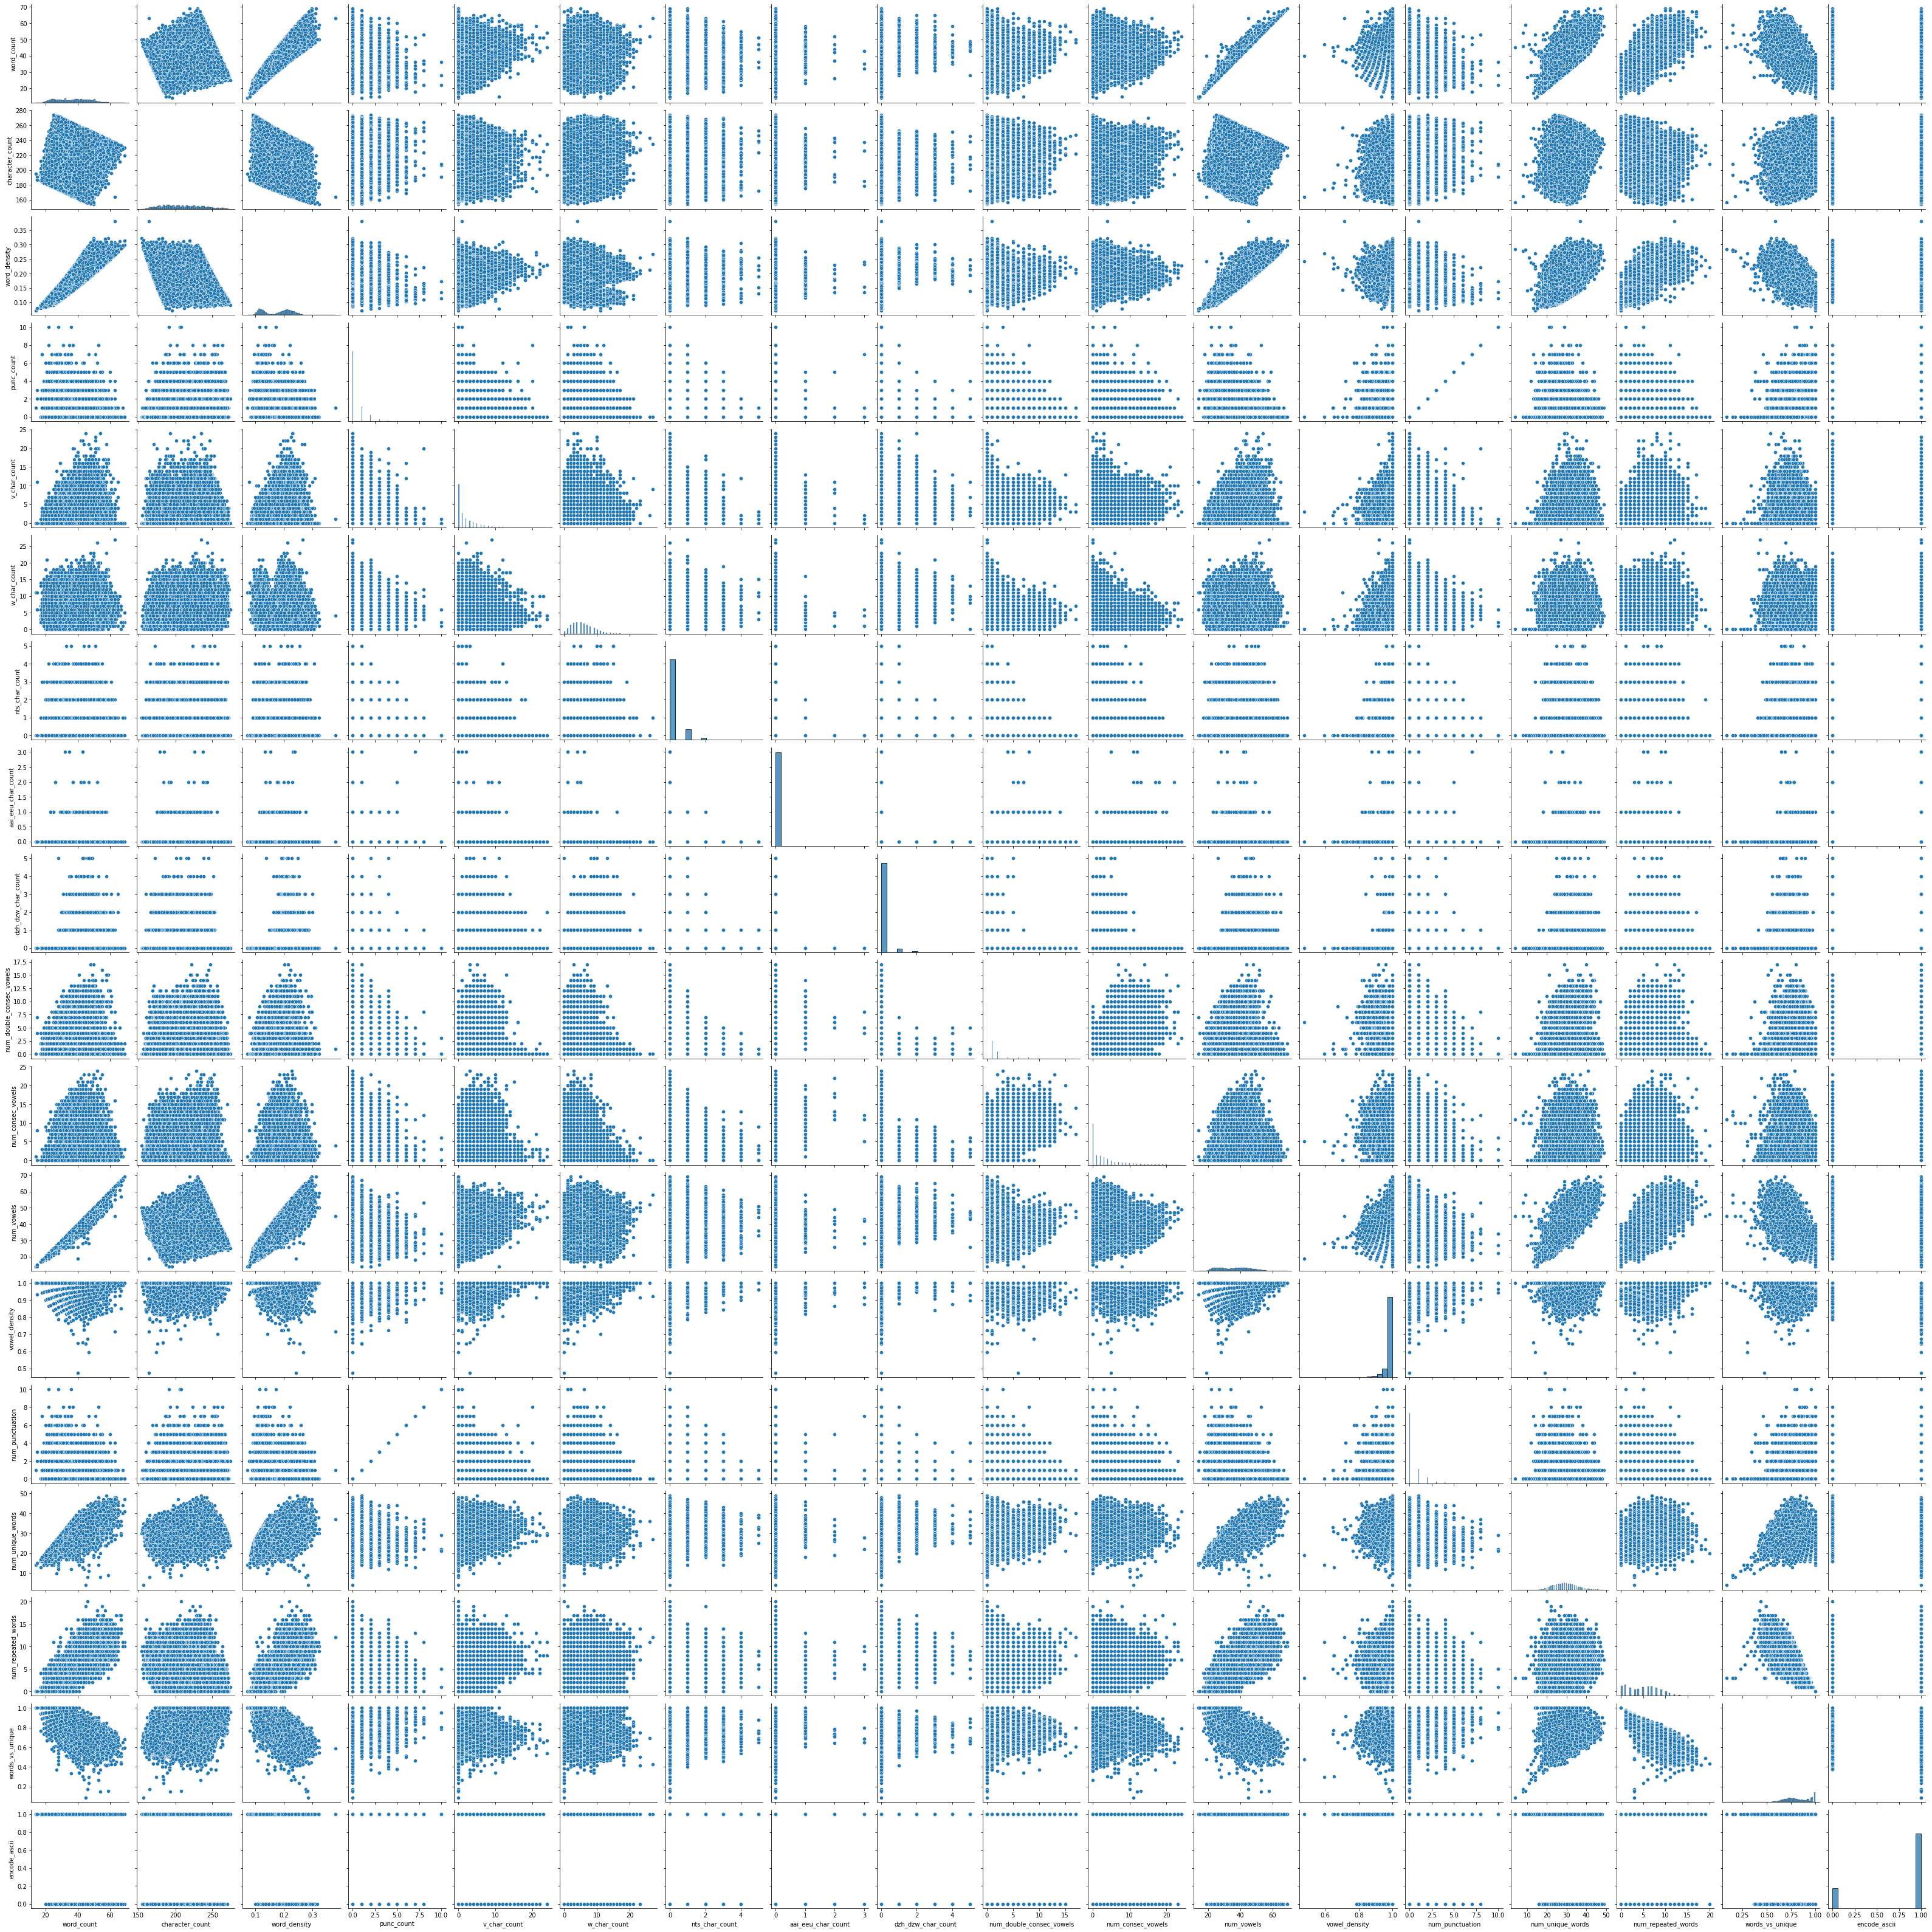

In [16]:
sns.pairplot(df)

In [17]:
#### text cleaning

def messages_processing(message):
    """
    Returns a sringof words, tokeninses and removes noise in the string
    
    Parameters:
        message (str): the string to be tokenised.
    Returns:
        words (str): returns a string of only relevant words
    """
    stopwords_list= stopwords.words('english')
    message= message.lower().strip().replace('_', ' ')
    message= re.sub(r"https\S+|www\S+https\S+", '', message, flags=re.MULTILINE)
    message= re.sub(r'\@w+|\#', '', message)
    message= re.sub(r'[^\w\s]','', message)
    token_words= word_tokenize(message)
    filtered_message= [word for word in token_words if word not in stopwords_list]
    
    return " ".join(filtered_message)

In [18]:
stemmer= PorterStemmer()
lemmatizer= WordNetLemmatizer()
def stemming(message):
    """
    Returns a list of stemmed words from a list of input words
    Parameters:
        message (str): string to be stemmed
    Returns:
        message (str): stemmed string
    """
    message= " ".join([stemmer.stem(word) for word in word_tokenize(message)])
    return message

def lemming(message):
    """
    Returns a list of lemma words from a list of input words
    Parameters:
        message (str): string to be converted
    Returns:
        message (str): lemmatized strings
    """
    message= " ".join([lemmatizer.lemmatize(word, pos='a') for word in word_tokenize(message)])
    return message

In [19]:
# creating a copy of the test and train df to use for preprocessing
train_p= train_data.copy()
test_p= test_data.copy()

# Applying the processing function to the message column of both data sets
train_p.text= train_p.copy()['text'].apply(messages_processing)
test_p.text= test_p.copy()['text'].apply(messages_processing)

In [20]:
train_p.loc[:,'stem_message']= train_p['text'].apply(stemming)
test_p.loc[:, 'stem_message']= test_p['text'].apply(stemming)
train_p.loc[:,'lemm_message']= train_p['text'].apply(lemming)
test_p.loc[:, 'lemm_message']= test_p['text'].apply(lemming)

In [21]:
# to vectorise the data
count_stem_train = CountVectorizer(stop_words='english', 
                                 ngram_range=(1,4),).fit(train_p['stem_message'])

In [21]:
tfid_stem_train = TfidfVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 2)).fit(train_p['stem_message'])

In [23]:
# to vectorise the data
count_lemm_train= CountVectorizer(stop_words='english', 
                                 ngram_range=(1,4),).fit(train_p['lemm_message'])

In [23]:
tfid_stem_train = TfidfVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 2)).fit(train_p['lemm_message'])

In [25]:
# Defining the target and label variables, I will be using stemmed messages for my target
X= train_p.copy()['lemm_message']
y= train_p.copy()['lang_id']

In [30]:
# Creating the predictor and label df from the train
X_pre_vect= train_p['lemm_message']
y= train_p['lang_id']
X= tfid_stem_train.transform(X_pre_vect)
# Normalizing the X_train
norm= preprocessing.MaxAbsScaler()
X= norm.fit_transform(X)

In [31]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, shuffle=True)

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [32]:
# create one or more ML models

logreg = MultinomialNB()
logreg.fit(X_train, y_train)

MultinomialNB()

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [33]:
y_pred= logreg.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       1.00      0.99      1.00       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      1.00      1.00       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



In [ ]:
# Choose best model 

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [ ]:
# discuss chosen methods 